# Power spectrum of CNTL and NCRF temperature

## Import package

In [28]:
import sys
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d

sys.path.append("/home/b11209013/Package")
import Theory as th #type: ignore
import DataProcess as dp #type: ignore


## Load data

In [29]:
# path
path: str = "/work/b11209013/2024_Research/MPAS/PC/"

# Load data
dims: dict[str, np.ndarray] = dict()
data: dict[str, np.ndarray] = dict()

## temperature of CNTL

with nc.Dataset(f"{path}CNTL_PC.nc", "r") as f:
    for key in f.dimensions.keys():
        dims[key] = f.variables[key][:]

    lat_lim: tuple[int] = np.where((dims["lat"] >= -5) & (dims["lat"] <= 5))[0]
    dims["lat"]  = dims["lat"][lat_lim]
    dims["time"] = dims["time"][:360]

    data["cntl"] = np.sum(f.variables["t"][:2, :, lat_lim, :360], axis=0)

## temperature of NCRF
with nc.Dataset(f"{path}NCRF_PC.nc", "r") as f:
    data["ncrf"] = np.sum(f.variables["t"][:2, :, lat_lim, :360], axis=0)

llon, llat, ltime = data["cntl"].shape

# remove climatology and zonal mean
for key in data.keys():
    data[key] -= data[key].mean(axis=(0, 2), keepdims=True)

## Processing data

### Symmetrize data

In [30]:
fmt = dp.Format(dims["lat"])

data_sym: dict[str, np.ndarray] = dict(
    (key, fmt.sym(data[key]))
    for key in data.keys()
)

data_asy: dict[str, np.ndarray] = dict(
    (key, fmt.asy(data[key]))
    for key in data.keys()
)

### Windowing data

In [31]:
# size of window
lsec: int = 120

# hanning window
hanning: np.ndarray = np.hanning(lsec)[:, None]

data_sym_hanning: dict[str, np.ndarray] = dict(
    (key, np.array([
        data_sym[key][:, i*60:i*60+120]
        for i in range(5)
    ]))
    for key in data_sym.keys()
)

data_asy_hanning: dict[str, np.ndarray] = dict(
    (key, np.array([
        data_asy[key][:, i*60:i*60+120]
        for i in range(5)
    ]))
    for key in data_asy.keys()
)

## Compute Power Spectrum

### Compute averaged Power Spectrum

In [32]:
def power_spec(data: np.ndarray) -> np.ndarray:
    
    data_fft: np.ndarray = np.fft.fft(data, axis=0)
    data_fft: np.ndarray = np.fft.ifft(data_fft, axis=1)

    ps = ((data_fft * data_fft.conj()).real) / np.prod(data.shape)

    return ps

power_spec_sym: dict[str, np.ndarray] = dict(
    (key, np.array([
        power_spec(data_sym_hanning[key][i])
        for i in range(5)
    ]).mean(axis=0))
    for key in data_sym_hanning.keys()
)

power_spec_asy: dict[str, np.ndarray] = dict(
    (key, np.array([
        power_spec(data_asy_hanning[key][i])
        for i in range(5)
    ]).mean(axis=0))
    for key in data_asy_hanning.keys()
)

### Compute Background of CNTL

In [33]:
def backgroud(data, nsmooth=20):
    kernel = np.array([1, 2, 1])
    kernel = kernel / kernel.sum()

    for _ in range(10):
        data = convolve1d(data, kernel, mode='nearest')

    data_low  = data[:data.shape[0]//2]
    data_high = data[data.shape[0]//2:]

    for _ in range(10):
        data_low = convolve1d(data_low, kernel, mode='nearest')

    for _ in range(40):
        data_high = convolve1d(data_high, kernel, mode='nearest')

    data = np.concatenate([data_low, data_high], axis=0)

    return data

cntl_bg = backgroud((power_spec_sym["cntl"]+power_spec_asy["cntl"])/2)

peak: dict[str, np.ndarray] = dict(
    (key, power_spec_sym[key]/cntl_bg)
    for key in power_spec_sym.keys()
)

## Plot 

### Axis setting

In [70]:
wn = np.fft.fftfreq(llon, d=1/llon)
fr = np.fft.fftfreq(lsec, d=1/4)

wn_v = np.fft.fftshift(wn)
fr_v = np.fft.fftshift(fr)

fr_ana, wn_ana = th.genDispersionCurves(Ahe=[8, 25, 90])

e_cond = np.where(wn_ana[3, 0, :]<=0)[0]

### Plotting

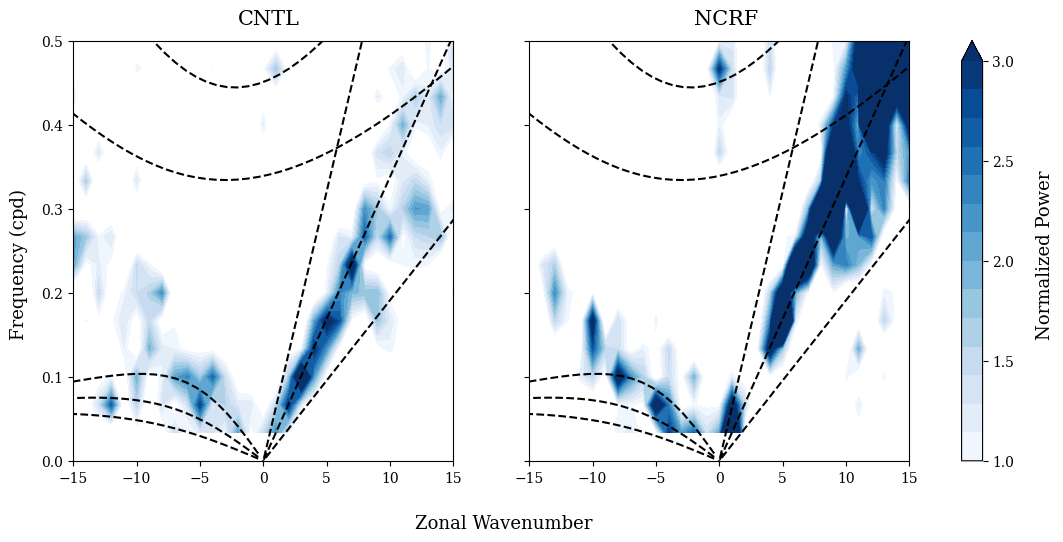

In [139]:
plt.rcParams["font.family"] = "serif"

fig, ax = plt.subplots(1, 2, figsize=(11, 6), sharey=True)
cntl_cf = ax[0].contourf(
    wn_v, fr_v[fr_v>0], np.fft.fftshift(peak["cntl"].T)[fr_v>0],
    levels=np.linspace(1, 3, 15), extend="max",
    cmap="Blues"
)
for i in range(3):
    ax[0].plot(wn_ana[3, i, :][e_cond], fr_ana[3, i, :][e_cond], "k--")
    ax[0].plot(wn_ana[4, i, :], fr_ana[4, i, :], "k--")
    ax[0].plot(wn_ana[5, i, :], fr_ana[5, i, :], "k--")
ax[0].set_xlim(-15, 15)
ax[0].set_ylim(0, 0.5)

ncrf_cf = ax[1].contourf(
    wn_v, fr_v[fr_v>0], np.fft.fftshift(peak["ncrf"].T)[fr_v>0],
    levels=np.linspace(1, 3, 15), extend="max",
    cmap="Blues"
)
for i in range(3):
    ax[1].plot(wn_ana[3, i, :][e_cond], fr_ana[3, i, :][e_cond], "k--")
    ax[1].plot(wn_ana[4, i, :], fr_ana[4, i, :], "k--")
    ax[1].plot(wn_ana[5, i, :], fr_ana[5, i, :], "k--")
ax[1].set_xlim(-15, 15)
ax[1].set_ylim(0, 0.5)

plt.text(-38, 0.52, "CNTL", fontsize=15)
plt.text(-2, 0.52, "NCRF", fontsize=15)
plt.text(-24, -0.08, "Zonal Wavenumber", fontsize=13)
plt.text(-56, 0.15, "Frequency (cpd)", rotation=90, fontsize=13)
plt.text(25, 0.15, "Normalized Power", rotation=90, fontsize=13)
plt.subplots_adjust(left=0.1, right=1.05, top=0.90, bottom=0.2)

cbar = plt.colorbar(ncrf_cf, ax=ax)
cbar.set_ticks(np.linspace(1, 3, 5))

plt.savefig("t_power_spec.png", dpi=300)